Course: WI4011-17 Computational Fluid Dynamics

Author: Bradley van Hoof, Leonardo Alessandro Lüder, Rosa Calegari

Academic year: 2023/2024

Delft University of Technology

In [54]:
import numpy
import scipy.sparse
import scipy.linalg
from matplotlib import pyplot as plt

In [55]:
def generate_mesh_2D(x_min, x_max, y_min, y_max, n_cells_x, n_cells_y):
    
    n_vertices_x = n_cells_x + 1
    n_vertices_y = n_cells_y + 1
    n_cells = n_cells_x * n_cells_y

    x, y = numpy.meshgrid(numpy.linspace(x_min, x_max, n_vertices_x), numpy.linspace(y_min, y_max, n_vertices_y))
    vertices = numpy.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])

    cells = numpy.zeros([n_cells, 4], dtype=numpy.int64)
    for j in range(0, n_cells_y):
        for i in range(0, n_cells_x):
            k = i + n_cells_x*j  

            cells[k, 0] = (i) + (n_cells_x + 1)*(j)  # the linear index of the lower left corner of the element
            cells[k, 1] = (i+1) + (n_cells_x + 1)*(j)  # the linear index of the lower right corner of the element
            cells[k, 2] = (i) + (n_cells_x + 1)*(j+1)  # the linear index of the upper left corner of the element
            cells[k, 3] = (i+1) + (n_cells_x + 1)*(j+1)  # the linear index of the upper right corner of the element

    return vertices, cells

In [56]:
def compute_local_mass_matrix():
    M_local = numpy.zeros([2, 2])
    M_local[0, 0] = 0.5
    M_local[1, 1] = 0.5
    
    return M_local

def compute_local_stiffness_matrix():
    N_local = numpy.ones([2, 2])
    N_local[0, 1] = -1.0
    N_local[1, 0] = -1.0
    
    return N_local

def compute_local_advection_matrix():
    A_local = 0.5*numpy.ones([2, 2])
    A_local[0, 0] = -0.5
    A_local[1, 0] = -0.5
    
    return A_local

In [58]:
def compute_u1_u2_matrix_2D():
    """
    The matrix u_1 plus u_2 is given by: integral B_i,x B_k dx integral B_j B_l dy
    Thus we need two times the local 1D mass matrix.
    """
    u1_u2_local = numpy.zeros([2, 4, 4])
    M_local_1D = compute_local_mass_matrix()
    Adv_local_1D = compute_local_advection_matrix()
    u1_u2_local[0] = numpy.kron(M_local_1D, Adv_local_1D)
    u1_u2_local[1] = numpy.kron(Adv_local_1D, M_local_1D)
    return u1_u2_local

def compute_eps_plus_tau_u_squared_matrix_2D():
    """
    The matrix eps + tau u_1^2 is given by:  integral B_i,x B_k,x dx integral B_j B_l dy
    Thus we need 1 time the local 1D mass matrix and 1 time the local 1D stiffness matrix.
    The information for u_1 is stored in its zeroth entry and for u_2 in its first entry.
    """
    eps_plus_tau_u_sqared= numpy.zeros([2, 4, 4])
    M_local_1D = compute_local_mass_matrix()
    N_local_1D = compute_local_stiffness_matrix()
    eps_plus_tau_u_sqared[0] = numpy.kron(M_local_1D, N_local_1D)
    eps_plus_tau_u_sqared[1] = numpy.kron(N_local_1D, M_local_1D)
    return eps_plus_tau_u_sqared

def compute_tau_u_1_u_2_matrix_2D():
    """
    The matrix tau u_1 u_2 is given by:  integral B_i,x B_k dx integral B_j B_l,y dy
    Thus we need 2 times the local 1D advection matrix.
    The information for u_1 is stored in its zeroth entry and for u_2 in its first entry.
    """
    A_local_1D = compute_local_advection_matrix()
    tau_u_1_u_2 = numpy.kron(A_local_1D, A_local_1D)
    return tau_u_1_u_2


In [59]:
def compute_global_u1_plus_u2_matrix_2D(vertices, cells, u):


    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]

    N_row_idx = numpy.zeros([n_cells, 4, 4])
    N_col_idx = numpy.zeros([n_cells, 4, 4]) 
    N_data = numpy.zeros([n_cells, 4, 4])

    delta_x = (vertices[cells[:, 1], 0] - vertices[cells[:, 0], 0]).flatten()
    delta_y = (vertices[cells[:, 2], 1] - vertices[cells[:, 0], 1]).flatten()

    u1_plus_u2_local = compute_u1_u2_matrix_2D()
    
    for cell_idx, cell in enumerate(cells):
        col_idx, row_idx = numpy.meshgrid(cell, cell)
        N_row_idx[cell_idx, :, :] = row_idx
        N_col_idx[cell_idx, :, :] = col_idx

        N_data[cell_idx, :, :] = u[0]*u1_plus_u2_local[0] * delta_x[cell_idx]  + u[1]*  u1_plus_u2_local[1] * delta_y[cell_idx]

    N_global = scipy.sparse.csr_array((N_data.flatten(), (N_row_idx.flatten(), N_col_idx.flatten())), shape=(n_vertices, n_vertices))

    return N_global

def compute_global_eps_plus_tau_u_squared_matrix_2D(vertices, cells, u, tau, eps):

    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]

    N_row_idx = numpy.zeros([n_cells, 4, 4])
    N_col_idx = numpy.zeros([n_cells, 4, 4]) 
    N_data = numpy.zeros([n_cells, 4, 4])

    eps_plus_tau_u_squared_local = compute_eps_plus_tau_u_squared_matrix_2D()
    
    for cell_idx, cell in enumerate(cells):
        col_idx, row_idx = numpy.meshgrid(cell, cell)
        N_row_idx[cell_idx, :, :] = row_idx
        N_col_idx[cell_idx, :, :] = col_idx

        N_data[cell_idx, :, :] = (eps + tau[cell_idx]*u[0]**2)*  eps_plus_tau_u_squared_local[0] + (eps + tau[cell_idx]*u[1]**2)*  eps_plus_tau_u_squared_local[1]

    N_global = scipy.sparse.csr_array((N_data.flatten(), (N_row_idx.flatten(), N_col_idx.flatten())), shape=(n_vertices, n_vertices))

    return N_global

def compute_global_tau_u_1_u_2_matrix_2D(vertices, cells, u, tau):

    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]

    N_row_idx = numpy.zeros([n_cells, 4, 4])
    N_col_idx = numpy.zeros([n_cells, 4, 4]) 
    N_data = numpy.zeros([n_cells, 4, 4])

    tau_u_1_u_2_local = compute_tau_u_1_u_2_matrix_2D()
    
    for cell_idx, cell in enumerate(cells):
        col_idx, row_idx = numpy.meshgrid(cell, cell)
        N_row_idx[cell_idx, :, :] = row_idx
        N_col_idx[cell_idx, :, :] = col_idx

        N_data[cell_idx, :, :] = 2*tau[cell_idx]*(u[0]*u[1])*  tau_u_1_u_2_local

    N_global = scipy.sparse.csr_array((N_data.flatten(), (N_row_idx.flatten(), N_col_idx.flatten())), shape=(n_vertices, n_vertices))

    return N_global


In [60]:

def compute_forcing_term_2D(f, vertices, cells):
    
    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]
    delta_x = (vertices[cells[:, 1], 0] - vertices[cells[:, 0], 0]).flatten()
    delta_y = (vertices[cells[:, 2], 1] - vertices[cells[:, 0], 1]).flatten()
    
    F = numpy.zeros(n_vertices)
    for cell_idx, cell in enumerate(cells):
        f_at_cell_vertices = f(vertices[cell])
        F[cell] += 0.25 * f_at_cell_vertices * delta_x[cell_idx] * delta_y[cell_idx]
    return F

In [61]:
def coth(x):
    with numpy.errstate(over='ignore', invalid='ignore'):
        # For large positive x, coth(x) approaches 1
        # For large negative x, coth(x) approaches -1
        large_x_mask = numpy.abs(x) > 700  # Threshold before exp(x) overflows
        coth_x = numpy.zeros_like(x)
        coth_x[~large_x_mask] = numpy.cosh(x[~large_x_mask]) / numpy.sinh(x[~large_x_mask])
        coth_x[x > 700] = 1.0  # coth(x) for large positive x
        coth_x[x < -700] = -1.0  # coth(x) for large negative x
    return coth_x
def compute_tau(vertices, cells, u, epsilon):
    
    delta_x = (vertices[cells[:, 1], 0] - vertices[cells[:, 0], 0]).flatten()
    delta_y = (vertices[cells[:, 2], 1] - vertices[cells[:, 0], 1]).flatten()

    Pe_h1 = u[0] * delta_x / (2.0 * epsilon)
    Pe_h2 = u[1] * delta_y / (2.0 * epsilon)

    beta_1 = numpy.zeros_like(Pe_h1)
    beta_2 = numpy.zeros_like(Pe_h2)

    beta_1 = numpy.where(Pe_h1 != 0.0, coth(Pe_h1) - 1.0/Pe_h1, 0.0)
    beta_2 = numpy.where(Pe_h2 != 0.0, coth(Pe_h2) - 1.0/Pe_h2, 0.0)


    eps_over = (beta_1 * u[0] * delta_x + beta_2 * u[1] * delta_y)/2.0

    tau = eps_over / (numpy.linalg.norm(u)**2)
    return tau

In [62]:
x_min = 0.0
x_max = 1.0
y_min = 0.0
y_max = 1.0

n_cells_x = 10  # Question's mesh
n_cells_y = 10  # Question's mesh

n_cells_x_ref = 101  # Refined mesh for reference solution
n_cells_y_ref = 101  # Refined mesh for reference solution

u = numpy.array([1.0, 0.0])

epsilon_big = 10e-2
epsilon_small = 10e-6

solution_choice = 2  # 0: question's text
                     # 1: manufactured solution

                      
if solution_choice == 2:
    f = lambda point: numpy.zeros(point.shape[0])
    plot_phi_exact = False

# Generate the meshes
vertices, cells = generate_mesh_2D(x_min, x_max, y_min, y_max, n_cells_x, n_cells_y)
vertices_ref, cells_ref = generate_mesh_2D(x_min, x_max, y_min, y_max, n_cells_x_ref, n_cells_y_ref)

def func_phi_left(y_index, threshold):
    return numpy.where(y_index < threshold, 1, 0)

phi_left = 0.0
phi_right = 0.0
phi_bottom = 1.0
phi_top = 0.0

def solve_conv_diff_SUPG(u, epsilon, phi_left, phi_right, phi_bottom, phi_top, n_cells_x, n_cells_y, vertices, cells, tauzero = False):
    if tauzero:
        tau = numpy.zeros(n_cells_x*n_cells_y)
    elif not tauzero:
        tau = compute_tau(vertices, cells, u, epsilon)
    
    u1_plus_u2_global = compute_global_u1_plus_u2_matrix_2D(vertices, cells, u)
    u1_plus_u2_global.toarray()

    eps_plus_tau_u_squared_global = compute_global_eps_plus_tau_u_squared_matrix_2D(vertices, cells, u, tau, epsilon)
    eps_plus_tau_u_squared_global.toarray()
    
    tau_u_1_u_2_global = compute_global_tau_u_1_u_2_matrix_2D(vertices, cells, u, tau)
    tau_u_1_u_2_global.toarray()


    # Setup the global system matrix
    S = u1_plus_u2_global + eps_plus_tau_u_squared_global + tau_u_1_u_2_global

    # Compute the right hand side
    F = compute_forcing_term_2D(f, vertices, cells)
  
    i_idx = numpy.zeros(n_cells_y + 1, dtype=numpy.int64)
    j_idx = numpy.arange(0, n_cells_y + 1)
    threshhold = j_idx[-1]/5
    left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
    S[left_basis_indices, :] = 0.0
    phi_left = func_phi_left(j_idx, threshhold)
    for i,basis_idx in enumerate(left_basis_indices):
        S[basis_idx, basis_idx] = 1.0
        F[basis_idx] = phi_left[i] # evaluate phi_left at the y-coordinate of the node
        
    
    # Right boundary
    i_idx = n_cells_x*numpy.ones(n_cells_y + 1, dtype=numpy.int64)
    j_idx = numpy.arange(0, n_cells_y + 1)
    left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
    S[left_basis_indices, :] = 0.0
    for basis_idx in left_basis_indices:
        S[basis_idx, basis_idx] = 1.0
        F[basis_idx] = phi_right  # note that phi_right is contant, if not, this needs to be changed

    # Bottom boundary
    i_idx = numpy.arange(0, n_cells_x + 1)
    j_idx = numpy.zeros(n_cells_x + 1, dtype=numpy.int64)
    left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
    S[left_basis_indices, :] = 0.0
    for basis_idx in left_basis_indices:
        S[basis_idx, basis_idx] = 1.0
        F[basis_idx] = phi_bottom  # note that phi_bottom is contant, if not, this needs to be changed

    # Top boundary
    i_idx = numpy.arange(0, n_cells_x + 1)
    j_idx = n_cells_y*numpy.ones(n_cells_x + 1, dtype=numpy.int64)
    left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
    S[left_basis_indices, :] = 0.0
    for basis_idx in left_basis_indices:
        S[basis_idx, basis_idx] = 1.0
        F[basis_idx] = phi_top  # note that phi_top is contant, if not, this needs to be changed

    # Solve the system 
    phi_h = scipy.sparse.linalg.spsolve(S, F)

    return phi_h


c:\Users\leolu\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\leolu\AppData\Local\Temp\ipykernel_5004\3139056972.py:7: RuntimeWarning: divide by zero encountered in divide
  coth_x[~large_x_mask] = numpy.cosh(x[~large_x_mask]) / numpy.sinh(x[~large_x_mask])
C:\Users\leolu\AppData\Local\Temp\ipykernel_5004\3139056972.py:23: RuntimeWarning: divide by zero encountered in divide
  beta_2 = numpy.where(Pe_h2 != 0.0, coth(Pe_h2) - 1.0/Pe_h2, 0.0)
C:\Users\leolu\AppData\Local\Temp\ipykernel_5004\3139056972.py:23: RuntimeWarning: invalid value encountered in subtract
  beta_2 = numpy.where(Pe_h2 != 0.0, coth(Pe_h2) - 1.0/Pe_h2, 0.0)


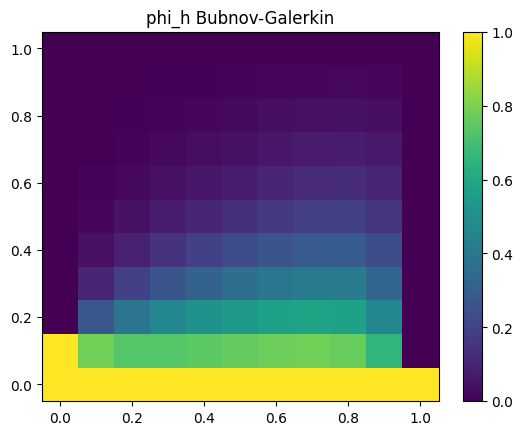

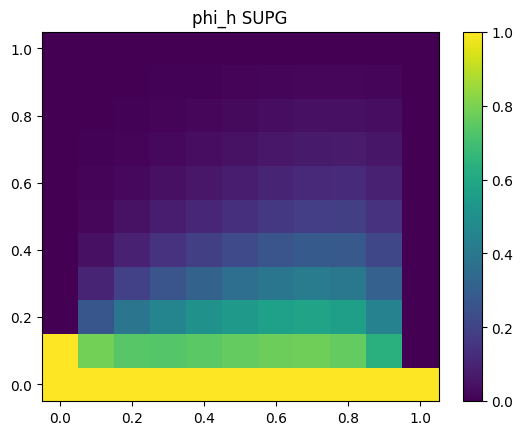

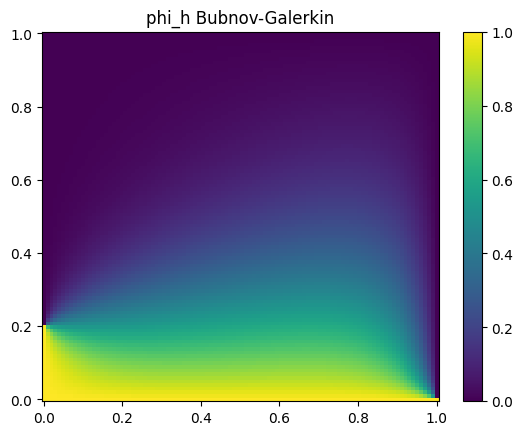

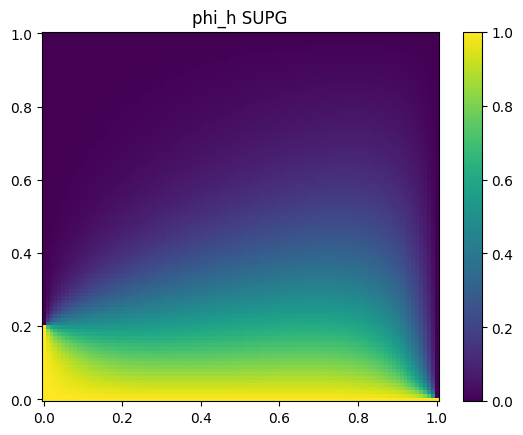

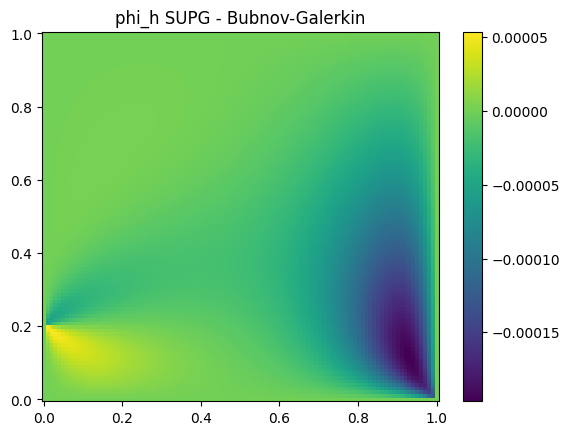

In [63]:
#n_cells = 10 x 10
#Solve for big epsilon and tau zero (Bubnov Galerkin)
phi_h_eps_big_tau_zero = solve_conv_diff_SUPG(u, epsilon_big, phi_left, phi_right, phi_bottom, phi_top, n_cells_x, n_cells_y, vertices, cells, tauzero = True)
#Solve for big epsilon and tau not zero (SUPG)
phi_h_eps_tau_not_zero = solve_conv_diff_SUPG(u, epsilon_big, phi_left, phi_right, phi_bottom, phi_top, n_cells_x, n_cells_y, vertices, cells, tauzero = False)

#n_cells = 100 x 100
#Solve for big epsilon and tau zero (Bubnov Galerkin)
phi_h_eps_big_tau_zero_ref = solve_conv_diff_SUPG(u, epsilon_big, phi_left, phi_right, phi_bottom, phi_top, n_cells_x_ref, n_cells_y_ref, vertices_ref, cells_ref, tauzero = True)
#Solve for big epsilon and tau not zero (SUPG)
phi_h_eps_tau_not_zero_ref = solve_conv_diff_SUPG(u, epsilon_big, phi_left, phi_right, phi_bottom, phi_top, n_cells_x_ref, n_cells_y_ref, vertices_ref, cells_ref, tauzero = False)

# Plot solution
plt.figure()
plt.pcolormesh(vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1), vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1), phi_h_eps_big_tau_zero.reshape(n_cells_y+1, n_cells_x+1))  # plot the error
plt.colorbar()
plt.title("phi_h Bubnov-Galerkin")
plt.savefig('./Results/2D_BubG_eps_big_coarse.pdf', transparent=None, dpi='figure', format='pdf')


plt.figure()
plt.pcolormesh(vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1), vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1), phi_h_eps_tau_not_zero.reshape(n_cells_y+1, n_cells_x+1))  # plot the error
plt.colorbar()
plt.title("phi_h SUPG")
plt.savefig('./Results/2D_SUPG_eps_big_coarse.pdf', transparent=None, dpi='figure', format='pdf')

plt.figure()
plt.pcolormesh(vertices_ref[:, 0].reshape(n_cells_y_ref+1, n_cells_x_ref+1), vertices_ref[:, 1].reshape(n_cells_y_ref+1, n_cells_x_ref+1), phi_h_eps_big_tau_zero_ref.reshape(n_cells_y_ref+1, n_cells_x_ref+1))  # plot the error
plt.colorbar()
plt.title("phi_h Bubnov-Galerkin")
plt.savefig('./Results/2D_BubG_eps_big_fine.pdf', transparent=None, dpi='figure', format='pdf')


plt.figure()
plt.pcolormesh(vertices_ref[:, 0].reshape(n_cells_y_ref+1, n_cells_x_ref+1), vertices_ref[:, 1].reshape(n_cells_y_ref+1, n_cells_x_ref+1), phi_h_eps_tau_not_zero_ref.reshape(n_cells_y_ref+1, n_cells_x_ref+1))  # plot the error
plt.colorbar()
plt.title("phi_h SUPG")
plt.savefig('./Results/2D_SUPG_eps_big_fine.pdf', transparent=None, dpi='figure', format='pdf')


plt.figure()
plt.pcolormesh(vertices_ref[:, 0].reshape(n_cells_y_ref+1, n_cells_x_ref+1), vertices_ref[:, 1].reshape(n_cells_y_ref+1, n_cells_x_ref+1), phi_h_eps_tau_not_zero_ref.reshape(n_cells_y_ref+1, n_cells_x_ref+1)-phi_h_eps_big_tau_zero_ref.reshape(n_cells_y_ref+1, n_cells_x_ref+1))  # 
plt.colorbar()
plt.title("phi_h SUPG - Bubnov-Galerkin")
plt.savefig('./Results/2D_SUPG_minus_BubG_eps_big_fine.pdf', transparent=None, dpi='figure', format='pdf')


c:\Users\leolu\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\leolu\AppData\Local\Temp\ipykernel_5004\3139056972.py:7: RuntimeWarning: divide by zero encountered in divide
  coth_x[~large_x_mask] = numpy.cosh(x[~large_x_mask]) / numpy.sinh(x[~large_x_mask])
C:\Users\leolu\AppData\Local\Temp\ipykernel_5004\3139056972.py:23: RuntimeWarning: divide by zero encountered in divide
  beta_2 = numpy.where(Pe_h2 != 0.0, coth(Pe_h2) - 1.0/Pe_h2, 0.0)
C:\Users\leolu\AppData\Local\Temp\ipykernel_5004\3139056972.py:23: RuntimeWarning: invalid value encountered in subtract
  beta_2 = numpy.where(Pe_h2 != 0.0, coth(Pe_h2) - 1.0/Pe_h2, 0.0)


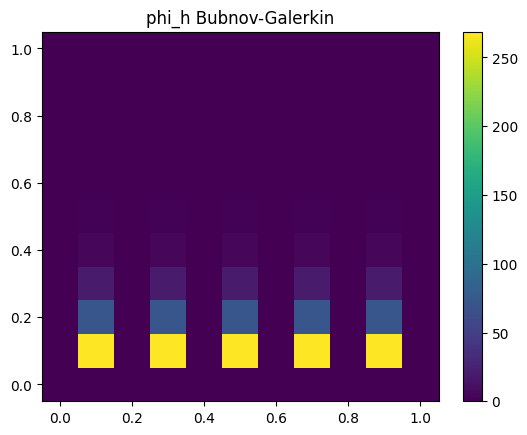

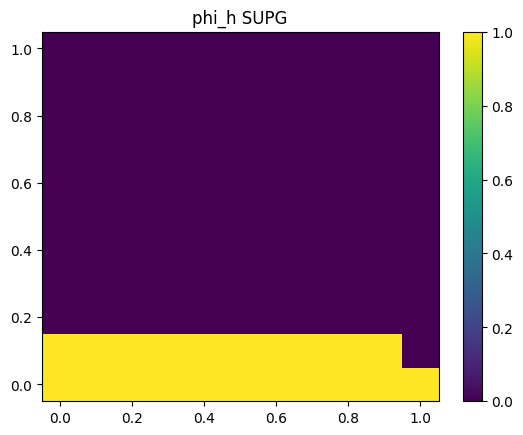

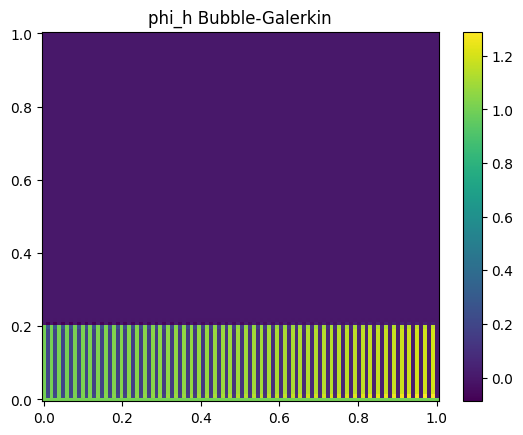

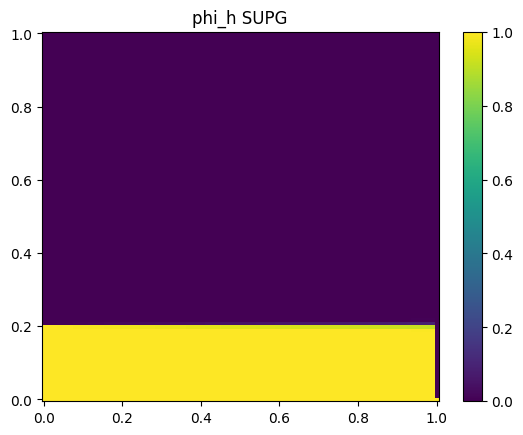

In [64]:
#small eps
#Bubnov Galerkin
phi_h_eps_small_tau_zero = solve_conv_diff_SUPG(u, epsilon_small, phi_left, phi_right, phi_bottom, phi_top, n_cells_x, n_cells_y, vertices, cells, tauzero = True)
#SUPG
phi_h_eps_small_tau_not_zero = solve_conv_diff_SUPG(u, epsilon_small, phi_left, phi_right, phi_bottom, phi_top, n_cells_x, n_cells_y, vertices, cells, tauzero = False)

#finer mesh
#Bubnov Galerkin
phi_h_eps_small_tau_zero_ref = solve_conv_diff_SUPG(u, epsilon_small, phi_left, phi_right, phi_bottom, phi_top, n_cells_x_ref, n_cells_y_ref, vertices_ref, cells_ref, tauzero = True)
#SUPG
phi_h_eps_small_tau_not_zero_ref = solve_conv_diff_SUPG(u, epsilon_small, phi_left, phi_right, phi_bottom, phi_top, n_cells_x_ref, n_cells_y_ref, vertices_ref, cells_ref, tauzero = False)

# Plot solution
plt.figure()
plt.pcolormesh(vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1), vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1), phi_h_eps_small_tau_zero.reshape(n_cells_y+1, n_cells_x+1))
plt.colorbar()
plt.title("phi_h Bubnov-Galerkin")
plt.savefig('./Results/2D_BubG_eps_small_coarse.pdf', transparent=None, dpi='figure', format='pdf')


plt.figure()
plt.pcolormesh(vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1), vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1), phi_h_eps_small_tau_not_zero.reshape(n_cells_y+1, n_cells_x+1))
plt.colorbar()
plt.title("phi_h SUPG")
plt.savefig('./Results/2D_SUPG_eps_small_coarse.pdf', transparent=None, dpi='figure', format='pdf')


plt.figure()
plt.pcolormesh(vertices_ref[:, 0].reshape(n_cells_y_ref+1, n_cells_x_ref+1), vertices_ref[:, 1].reshape(n_cells_y_ref+1, n_cells_x_ref+1), phi_h_eps_small_tau_zero_ref.reshape(n_cells_y_ref+1, n_cells_x_ref+1))  # plot the error
plt.colorbar()
plt.title("phi_h Bubble-Galerkin")
plt.savefig('./Results/2D_BubG_eps_small_fine.pdf', transparent=None, dpi='figure', format='pdf')


plt.figure()
plt.pcolormesh(vertices_ref[:, 0].reshape(n_cells_y_ref+1, n_cells_x_ref+1), vertices_ref[:, 1].reshape(n_cells_y_ref+1, n_cells_x_ref+1), phi_h_eps_small_tau_not_zero_ref.reshape(n_cells_y_ref+1, n_cells_x_ref+1))  # plot the error
plt.colorbar()
plt.title("phi_h SUPG")
plt.savefig('./Results/2D_SUPG_eps_small_fine.pdf', transparent=None, dpi='figure', format='pdf')

